# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchinfo
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from os import listdir


from torch.utils.data import DataLoader, Dataset

from os.path import join as pjoin

from torchmetrics.classification import MulticlassStatScores

from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image

# Const

In [2]:
DEVICE = torch.device("cuda")
DEVICE_CPU = torch.device("cpu")

EPOCHS = 5

BATCH_SIZE = 96

LEARNING_RATE = 0.005

PATH_TO_TRAIN = "C:\AI_PAK\AI\simpson\simpsons_train"
PATH_TO_TEST = "C:\AI_PAK\AI\simpson\simpsons_test"

LABELS = dict((name, index) for (index, name) in enumerate(listdir(PATH_TO_TRAIN)))
COUNT_LABELS = len(LABELS)

RESIZE = (64, 64)

MEAN = (0.5, 0.5, 0.5)
STD = (0.25, 0.25, 0.25)

# Transformer

In [3]:
TRANSFORM = transforms.Compose([
    transforms.Resize(size=RESIZE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Dataset To Train

In [4]:
class Image_Dataset(torch.utils.data.Dataset):
    def __init__(self):
        self.paths = list()
        self.labels = list()
        for label in LABELS: 
            elements = glob.glob(os.path.join(PATH_TO_TRAIN, label, "*.jpg"))
            self.paths.extend(elements)
            self.labels.extend([LABELS.get(label)] * len(elements))
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        with open(self.paths[index], "rb") as file:
            image = Image.open(file).convert("RGB")
        image = TRANSFORM(image)
        return image, torch.tensor(self.labels[index], dtype=torch.long)

In [5]:
full_dataset = Image_Dataset()
generator = torch.Generator().manual_seed(42)
dataset_train, dataset_valid = torch.utils.data.random_split(full_dataset, [0.9, 0.1], generator=generator)
dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) 
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) 

# Model

In [6]:
class Block(nn.Module):
    def __init__(self, inC: int, outC: int, mult: int) -> None:
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.silu = nn.SiLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels=inC, out_channels=inC*mult, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(inC*mult)
        self.conv2 = nn.Conv2d(in_channels=inC*mult, out_channels=inC*mult, kernel_size=3, padding=1, groups=inC*mult)
        self.bn2 = nn.BatchNorm2d(inC*mult)
        self.conv3 = nn.Conv2d(in_channels=inC*mult, out_channels=outC, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(outC)

        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels=inC, out_channels=outC, kernel_size=1),
            nn.BatchNorm2d(outC)
        )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.silu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.downsample(identity)

        out += identity
        out = self.silu(out)
        x = out
        
        return x

In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.cv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32)
        )
        self.cv2 = nn.Sequential(
            Block(32, 32, 6),
            Block(32, 32, 6),
            Block(32, 64, 6),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.cv3 = nn.Sequential(
            Block(64, 64, 6),
            Block(64, 64, 6),
            Block(64, 64, 6),
            Block(64, 64, 6),
            Block(64, 64, 6),
            Block(64, 128, 6),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.cv4 = nn.Sequential(
            Block(128, 128, 6),
            Block(128, 128, 6),
            Block(128, 128, 6),
            Block(128, 256, 6),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.cv5 = nn.Sequential(
            Block(256, 256, 6),
            Block(256, 256, 6),
            Block(256, 512, 6),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.Linear(128, COUNT_LABELS)
        )
    
    def forward(self, x):
        x = self.cv1(x)
        x = self.cv2(x)
        x = self.cv3(x)
        x = self.cv4(x)
        x = self.cv5(x)

        x = self.fc(x)

        return x

In [8]:
model = Model().to(DEVICE)

In [9]:
# Info about model
print(model_sum := torchinfo.summary(model, depth=4, input_size=(BATCH_SIZE, 3, *RESIZE), row_settings=["var_names"], verbose=0, col_names=[
"input_size", "output_size", "num_params", "params_percent", "kernel_size", "mult_adds", "trainable"]))

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
Model (Model)                            [96, 3, 64, 64]           [96, 42]                  --                             --                   --                        --                        True
├─Sequential (cv1)                       [96, 3, 64, 64]           [96, 32, 32, 32]          --                             --                   --                        --                        True
│    └─Conv2d (0)                        [96, 3, 64, 64]           [96, 32, 64, 64]          128                         0.00%                   [1, 1]                    50,331,648                True
│    └─ReLU6 (1)                         [96, 32, 64, 64]          [96, 32, 64, 64]          --                             --                   --                        --              

c:\Users\pasha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\pasha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


# Save Weights

In [34]:
torch.save(model.state_dict(), "model_weights_25.pth")

# Load Weights

In [ ]:
model.load_state_dict(torch.load("model_weights.pth"))

# Train

In [10]:
loss_to_stats = []
loss_to_stats_valid = []

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001)

for epoch in range(EPOCHS):
    res = 0
    count = 0
    for images, labs in dataloader:
        model.train()
        optimizer.zero_grad()

        images, labs = images.to(DEVICE), labs.to(DEVICE)

        out = model(images)
        loss = criterion(out, labs)
        loss.backward()
        optimizer.step()
        
        print(f"epoch = {epoch}  loss = {loss} ")
        
        res += loss
        count += 1 
    loss_to_stats.append(res/count)
    res = 0
    count = 0
    for images, labs in dataloader_valid:
        model.eval()
        with torch.no_grad():
            images, labs = images.to(DEVICE), labs.to(DEVICE)

            out = model(images)
            loss = criterion(out, labs)
            res += loss
        count += 1 
    loss_to_stats_valid.append(res/count)

    print(f"\nepoch = {epoch} finish\n")

LEARNING_RATE *= 0.75

epoch = 0  loss = 0.12264755368232727 
epoch = 0  loss = 0.321853905916214 
epoch = 0  loss = 0.2780871093273163 
epoch = 0  loss = 0.1114422157406807 
epoch = 0  loss = 0.10395052284002304 
epoch = 0  loss = 0.17529189586639404 
epoch = 0  loss = 0.1203744113445282 
epoch = 0  loss = 0.15810610353946686 
epoch = 0  loss = 0.12095820903778076 
epoch = 0  loss = 0.16549290716648102 
epoch = 0  loss = 0.16288137435913086 
epoch = 0  loss = 0.2264898717403412 
epoch = 0  loss = 0.19362474977970123 
epoch = 0  loss = 0.30395057797431946 
epoch = 0  loss = 0.04096493870019913 
epoch = 0  loss = 0.15166893601417542 
epoch = 0  loss = 0.15032291412353516 
epoch = 0  loss = 0.1545899361371994 
epoch = 0  loss = 0.1787502020597458 
epoch = 0  loss = 0.15287944674491882 
epoch = 0  loss = 0.11851335316896439 
epoch = 0  loss = 0.24445785582065582 
epoch = 0  loss = 0.11079780012369156 
epoch = 0  loss = 0.1882804036140442 
epoch = 0  loss = 0.1715575009584427 
epoch = 0  loss = 0.135486319661140

# Loss On Train

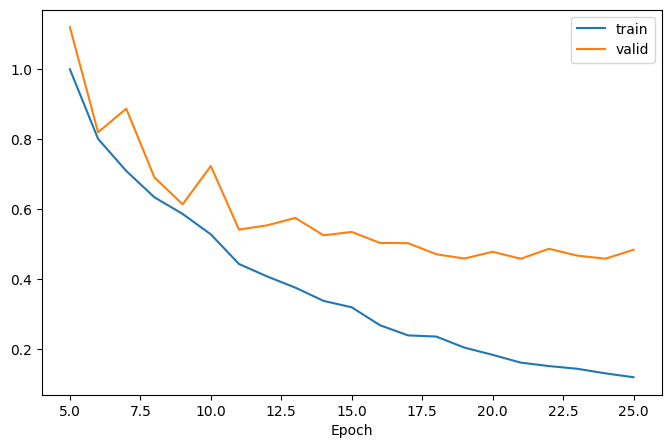

In [31]:
arr_train = np.array([i.item() for i in loss_to_stats])
arr_valid = np.array([i.item() for i in loss_to_stats_valid])

fig = plt.figure(figsize=(8, 5))

plt.plot(np.array([i + 1 for i in range(len(arr_train))][4:]), arr_train[4:], label='train')
plt.plot(np.array([i + 1 for i in range(len(arr_valid))][4:]), arr_valid[4:], label='valid')
plt.legend()
plt.xlabel("Epoch")

plt.show()

# Dataset for Test

In [15]:
res = list(LABELS.keys())
CLASSES = np.array(res)

class SimpsonTestDataset(Dataset):
    def __init__(self, img_dir):
        self.files = []
        for _, _, files in os.walk(img_dir):
            self.files += files
        self.calculateClasses()
        self.img_dir = img_dir

    def extractName(self, s):
        se = re.search(r"[a-zA-Z_]+[^\d]?", s)
        return se.group(0)[:-1]

    def calculateClasses(self):
        self.s = set()
        for i in self.files:
            self.s.add(self.extractName(i))
        return list(self.s)

    @property
    def classes(self):
        return list(self.s)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_path = pjoin(self.img_dir, self.files[index])
        with open(img_path, "rb") as file:
            image = Image.open(file).convert("RGB")
        label = self.extractName(self.files[index])

        image = TRANSFORM(image)
        label = np.where(CLASSES == label)[0][0]
        return image, label

In [16]:
test_dataset = SimpsonTestDataset(PATH_TO_TEST)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Test

In [32]:
stats = MulticlassStatScores(num_classes=COUNT_LABELS, average=None).to(DEVICE)

with torch.no_grad():
    model.eval()
    for images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        stats.update(outputs, labels)

tp, fp, tn, fn = stats._final_state()

# Metrics

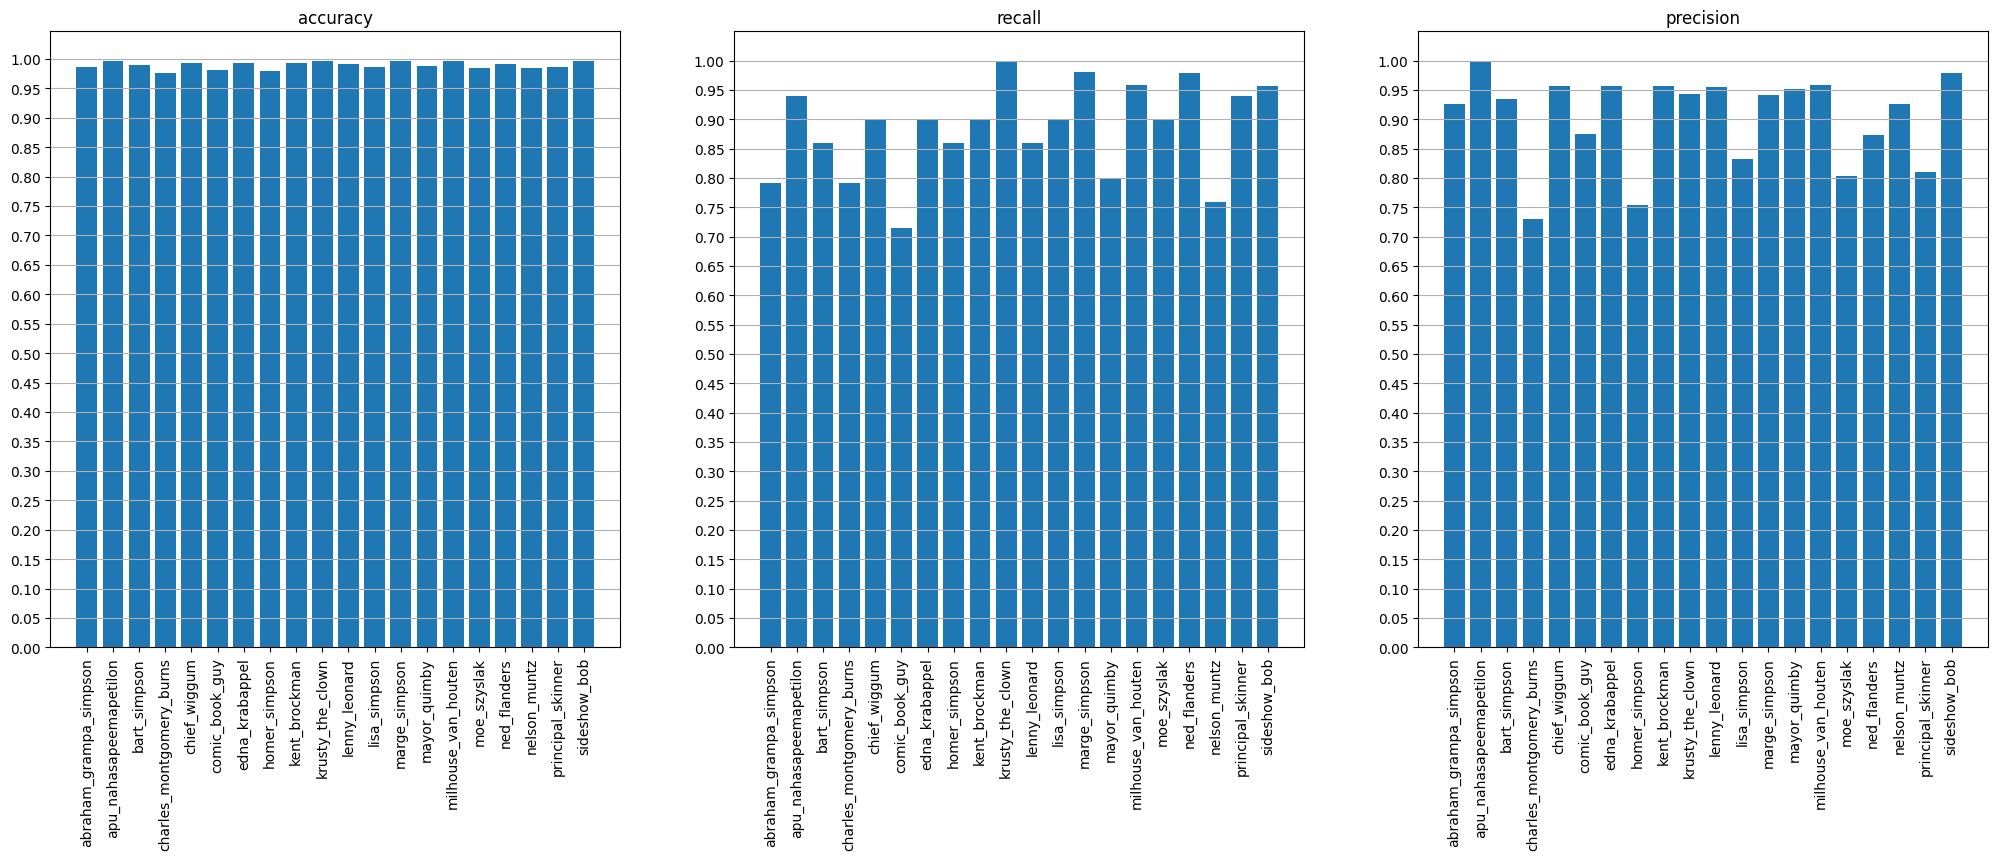



Test:
accuracy: 99.4517%
recall: 88.4692%
precision: 90.3600%
F: 89.4046%


In [33]:
def metric(a, b):
    return torch.nan_to_num(a / b)

def metrics_class(a, b):
    return {classname: val.item() for classname, val in zip(CLASSES, metric(a, b)) if classname in test_dataset.classes}

metrics_per_class = {"accuracy": metrics_class(tp + tn, tp + fp + tn + fn),
                     "recall": metrics_class(tp, tp + fn),
                     "precision": metrics_class(tp, tp + fp)}

def metrics_total(a, b, len=COUNT_LABELS):
    return sum(metric(a, b)) / len

metric_total = {"accuracy": metrics_total(tp + tn, tp + fp + tn + fn),
                "recall": metrics_total(tp, tp + fn, len(test_dataset.classes)),
                "precision": metrics_total(tp, tp + fp, len(test_dataset.classes))}


fig, axes = plt.subplots(1, 3, figsize=(25,8))

for (metricName, mVal), ax in zip(metrics_per_class.items(), axes):
        plt.sca(ax)
        plt.bar(mVal.keys(), mVal.values())
        plt.title(metricName)
        plt.grid(axis='y')
        plt.xticks(rotation=90)
        plt.yticks(ticks=np.arange(0, 1.01, 0.05))
plt.show()

result = f"""\n\nTest:
accuracy: {metric_total['accuracy']*100:.4f}%
recall: {metric_total['recall']*100:.4f}%
precision: {metric_total['precision']*100:.4f}%
F: {2 * metric_total['precision']*metric_total['recall']/(metric_total['precision']+metric_total['recall'])*100:.4f}%"""

print(result)

# Result

10 epoch 

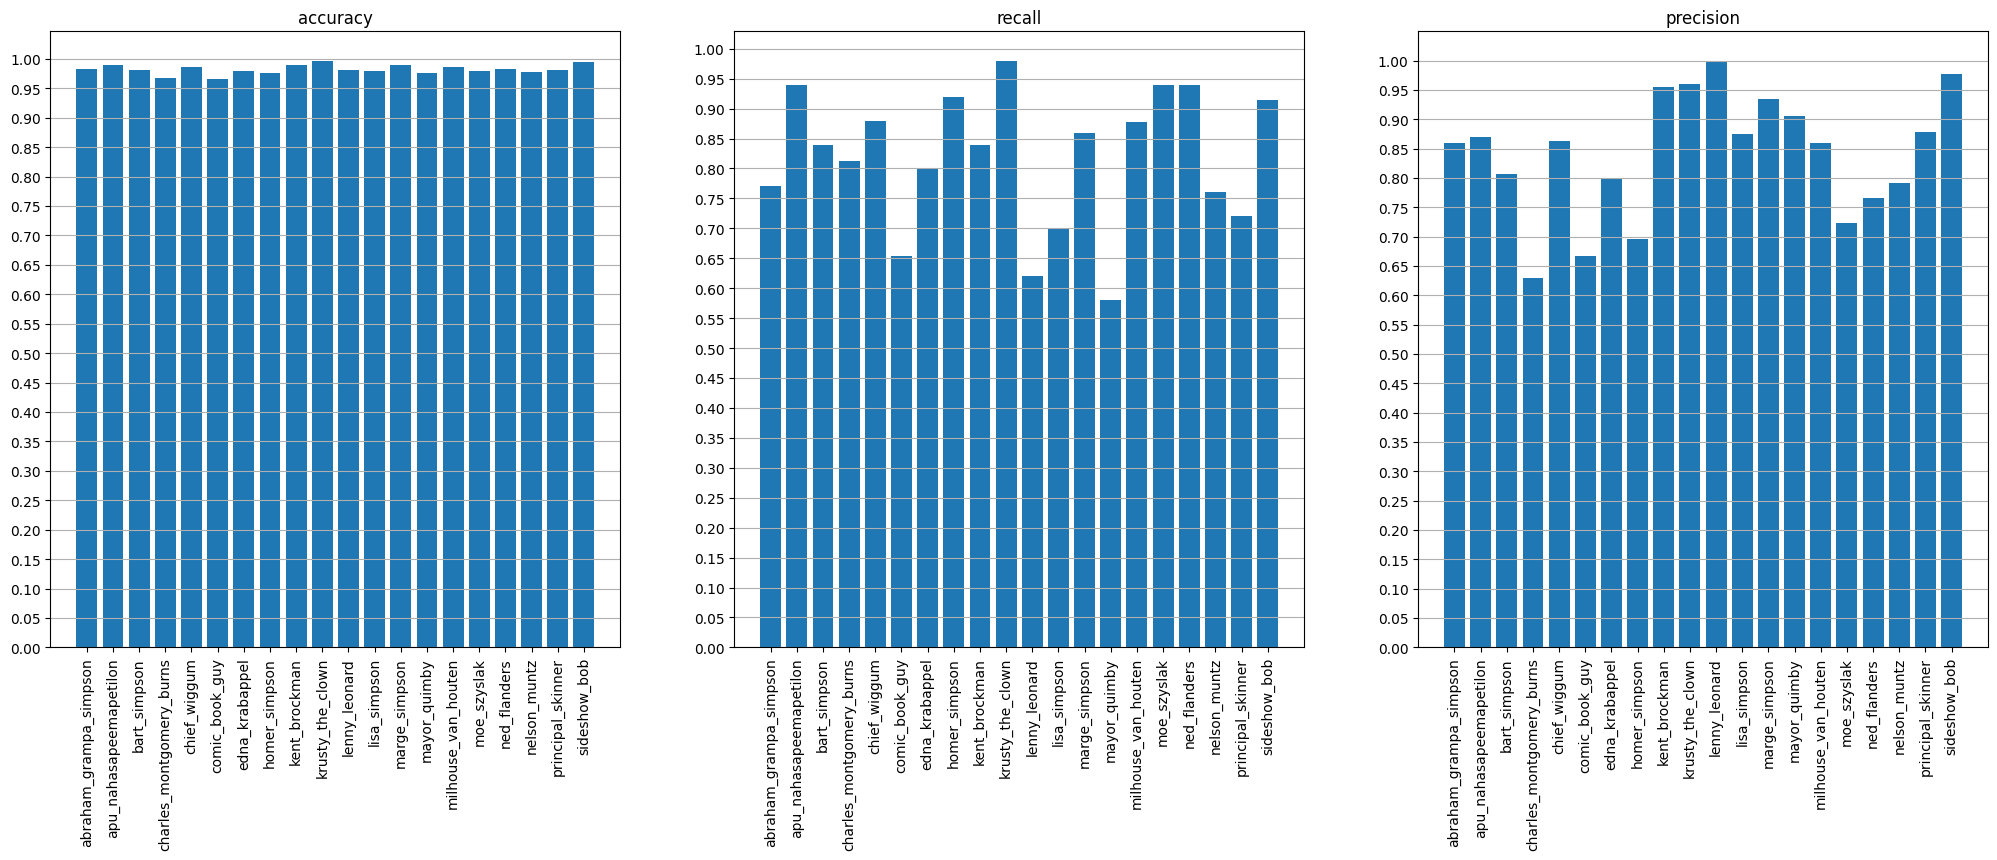

Test:

accuracy: 99.1294%

recall: 81.7381%

precision: 84.1102%

F: 82.9072%